In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from qiskit.circuit.library import RealAmplitudes, EfficientSU2, PauliFeatureMap, ZZFeatureMap
from qiskit_machine_learning.neural_networks import SamplerQNN
from qiskit.primitives import Sampler
from qiskit_machine_learning.connectors import TorchConnector
from qiskit_machine_learning.circuit.library import QNNCircuit
from qiskit.circuit import QuantumCircuit
from qiskit.circuit import ParameterVector
from qiskit.circuit.library import PhaseGate, TwoLocal
from sklearn.decomposition import PCA
import time

import torch
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

In [2]:
# load data
features = np.loadtxt('realdata.txt')
labels  = np.loadtxt('reallabels.txt')

In [4]:
scaler = MinMaxScaler()
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

f_train = scaler.fit_transform(X_train)
f_test = scaler.transform(X_test)

In [5]:
pca = PCA(n_components=3)
pca.fit(f_train)

f_train = pca.fit_transform(f_train)
f_test = pca.fit_transform(f_test)

In [6]:
print('f_train shape: ', f_train.shape)
print('f_test shape: ', f_test.shape)

f_train shape:  (5880, 3)
f_test shape:  (1470, 3)


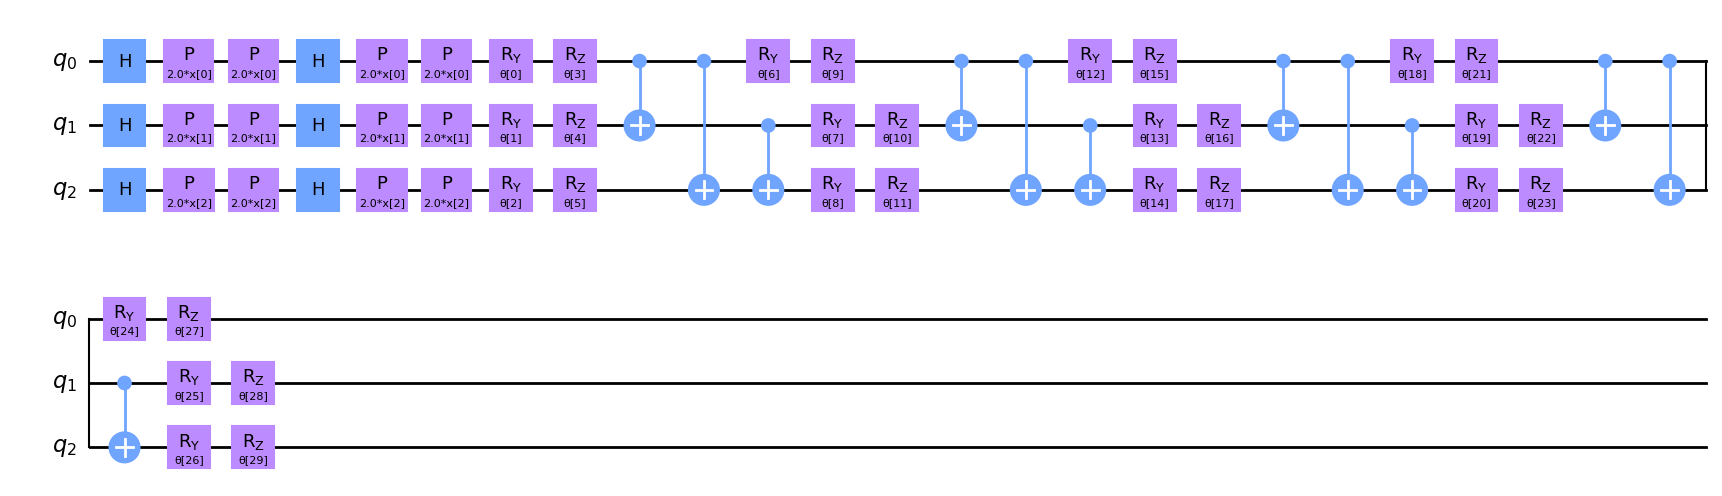

In [7]:
qubits = f_train.shape[1]

fm = PauliFeatureMap(qubits, reps=2, paulis=['Z','H'])
ansatz = EfficientSU2(qubits, reps=4, entanglement='full')

# create quantum circuit
qc = QNNCircuit(
    num_qubits=qubits,
    feature_map=fm,
    ansatz=ansatz
)

#visualize quantum circuit
qc.decompose().draw('mpl', style='clifford')

In [8]:
def interpret(bitstring):
    return int(bitstring) % 4

sampler = Sampler()

In [9]:
# Qiskit quantum neural network
qnn = SamplerQNN(
    circuit = qc,
    input_params = fm.parameters,
    weight_params = ansatz.parameters,
    output_shape = 4,
    interpret = interpret,
    sampler=sampler
)

In [10]:
# Create a PyTorch model using TorchConnector
model = TorchConnector(qnn)
# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)
# Convert training data to PyTorch tensors
X_train_tensor = torch.tensor(f_train, dtype=torch.float32) 
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)

In [11]:
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
batch_size = 7
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [12]:
# Training loop
epochs = 15
for epoch in range(epochs):
    start_time = time.time()  # Record the start time
    model.train()
    epoch_loss = 0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        output = model(X_batch)
        loss = F.mse_loss(output, y_batch)
        
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    
    end_time = time.time()  # Record the end time
    epoch_duration = (end_time - start_time) / 60  # time in minutes
    print(f'Epoch {epoch + 1}/{epochs}, Loss: {epoch_loss / len(train_loader)}, Time: {epoch_duration:.2f} minutes')


Epoch 1/15, Loss: 0.16659385615161487, Time: 6.84 minutes
Epoch 2/15, Loss: 0.12552137536307176, Time: 6.86 minutes
Epoch 3/15, Loss: 0.11843952753004573, Time: 6.86 minutes
Epoch 4/15, Loss: 0.11532684622687243, Time: 6.85 minutes
Epoch 5/15, Loss: 0.11342378904865612, Time: 6.86 minutes
Epoch 6/15, Loss: 0.11204871690965125, Time: 6.85 minutes
Epoch 7/15, Loss: 0.1110134734151264, Time: 6.85 minutes
Epoch 8/15, Loss: 0.11015722609258123, Time: 6.85 minutes
Epoch 9/15, Loss: 0.10951272859903319, Time: 6.86 minutes
Epoch 10/15, Loss: 0.10898847253549666, Time: 6.85 minutes
Epoch 11/15, Loss: 0.10862126555737285, Time: 6.85 minutes
Epoch 12/15, Loss: 0.10839250550738402, Time: 6.85 minutes
Epoch 13/15, Loss: 0.10825148806242006, Time: 6.85 minutes
Epoch 14/15, Loss: 0.10818838044291451, Time: 6.85 minutes
Epoch 15/15, Loss: 0.10813129050213666, Time: 6.85 minutes


In [13]:
# Convert test data to PyTorch tensors
X_test_tensor = torch.tensor(f_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

In [14]:
# Evaluate the model
model.eval()
with torch.no_grad():
    output = model(X_test_tensor)
    test_loss = F.mse_loss(output, y_test_tensor)
    predictions = torch.argmax(output, dim=1)
    actual = torch.argmax(y_test_tensor, dim=1)
    accuracy = (predictions == actual).float().mean()

In [15]:
print(f'Test set loss: {test_loss.item()}')
print(f'Test set accuracy: {accuracy.item() * 100:.2f}%')

Test set loss: 0.11005565524101257
Test set accuracy: 75.17%


Confusion Matrix
[[377   0   0   0]
 [  0 323   2  16]
 [  1  29 132 158]
 [  0  78  81 273]]


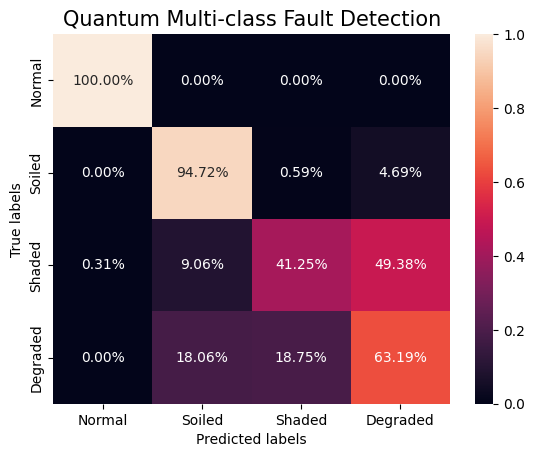

In [16]:
# Confusion Matrix and Heatmap
cm = confusion_matrix(actual, predictions)

l = ['Normal', 'Soiled', 'Shaded', 'Degraded']
column = [f'{label}' for label in l]
indices = [f'{label}' for label in l]
table = pd.DataFrame(cm, columns=column, index=indices)

print("Confusion Matrix")
print(cm)

# Normalize by truth labels
table_normalized = table.div(table.sum(axis=1), axis=0)

# Plotting the heatmap
color = None
sns.heatmap(table_normalized, annot=True, fmt='.2%', cmap=color)
plt.title("Quantum Multi-class Fault Detection", fontsize=15)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.rcParams.update({'font.size': 14})
plt.show()